# `freud` Hexatic Calculation and Plotting Examle 

Description: 
In this example we will open an unprocessed sample image via `opencv`, use `trackpy` to find point particles, and then analyze through the `freud` library. 

Author(s): Mason S. Sake 

Last Modified Date: July 28, 2025

## Open the sample dust cloud image and track the particles

First, set the correct path to the sample dust cloud image

In [4]:
#get abspath function from os library
from os.path import abspath

#define the relative path to the image
file_path = "../Examples/SampleData/sample_dust_cloud.png"
image_path = abspath(file_path) #create the image path


Now we need to load in the image and convert to grayscale with `opencv`

In [5]:
from cv2 import imread #imread function to open image
from cv2 import cvtColor #cvtColor to change to grayscale
from cv2 import COLOR_BGR2GRAY #BGR to Gray code argument 

#Read in the image
image = imread(image_path)

#Check the image is properly read in 
if image is None: 
    print("Unable to load frame.") 
else: 
    #If we have the image convert it to gray scale
    image = cvtColor(image, COLOR_BGR2GRAY)

Next, we track the particles with `trackpy`

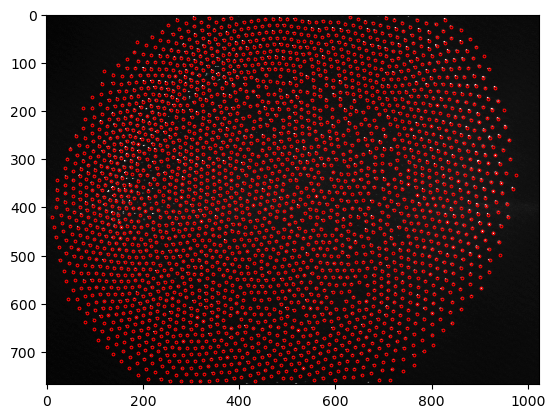

<Axes: >

In [6]:
from trackpy import locate 
from trackpy import annotate

#Do a basic particle tracking, for the above example a diameter size of 11 is appropriate 
track_df = locate(image, 11)
#Now we can annotate the tracked particles
annotate(track_df,image,plot_style={'markersize':0.75})

# Set-up and Analyze with `freud`

Now we have the trackpy data frame of the tracked particles. We need to prepare the tracked points to create a freud box. 
* Pull the 2D points from the dataframe and create a 3D point matrix (zs set to zero)
* Find the dimensions of the freud box 
* Note that the freud box is Lx by Ly by Lz indexed from the center (i.e. sides of the box are [-L/2,L/2)), so we need to modify the points to appropriately fit inside this paradigm 

In [ ]:
import numpy as np #go ahead and grab numpy

#Pull the x and y values from the dataframe 
pointsx = track_df['x'].to_numpy() 
pointsy = track_df['y'].to_numpy() 



#Since this is a 2D examle, freud boxes expect 3D corrdinates. We'll set z coords to zero
num_rows = pointsx.shape[0] #index off x coords to figure out number of rows
zeros_col = np.zeros((num_rows,1), dtype=pointsx.dtype) #generate a column of zeros

#Stack the columns into a single matrix 
points = np.column_stack((pointsx, pointsy, zeros_col))

#Find the min and max coordinates for below
x_min = np.min(points[:,0]) 
y_min = np.min(points[:,1])
x_max = np.max(points[:,0])
y_max = np.max(points[:,1]) 

#Now let's get the box lengths 
Lx = int(x_max - x_min)
Ly = int(y_max - y_min)

#Modify the points values to fit in freud box 
points[:,0] = points[:,0] - Lx/2 
points[:,1] = points[:,1] - Ly/2 

* import `freud` and create the `freud.box`
* compute the voronoi object

In [ ]:
import freud 

#Create the freud box 
box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=0, xy=0, xz=0, yz=0) #setting the length and cross terms for a 2D box
box.periodic = [False, False, False] #turning off the periodic conditions in all directions

#Compute the vornoi object 
voro = freud.locality.Voronoi() 
voro.compute((box,points))


Go ahead and import `matplotlib` for plotting 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

#### Vornoi Plot

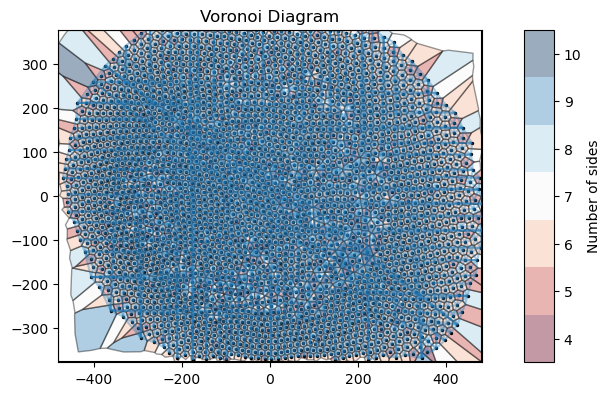

In [ ]:
plt.figure()
ax = plt.gca()
voro.plot(ax=ax, color_by = 'sides', cmap = "RdBu")

"""For adding lines to connect the scatter points uncomment bellow"""
#nlist = voro.nlist
#line_data = np.asarray([[points[i], points[i] + box.wrap(points[j] - points[i])] for i, j in nlist])[:, :, :2]
#line_collection = matplotlib.collections.LineCollection(line_data, alpha=0.2)
#ax.add_collection(line_collection)

ax.scatter(points[:, 0], points[:, 1], s=2, c="k")
plt.show()

#### Minkowski Order Metric Plots 
Now find and plot the Minkowski order metric and color the Vornoi cells to scale

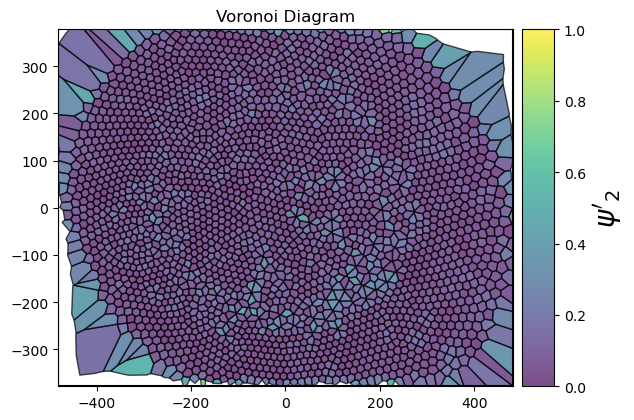

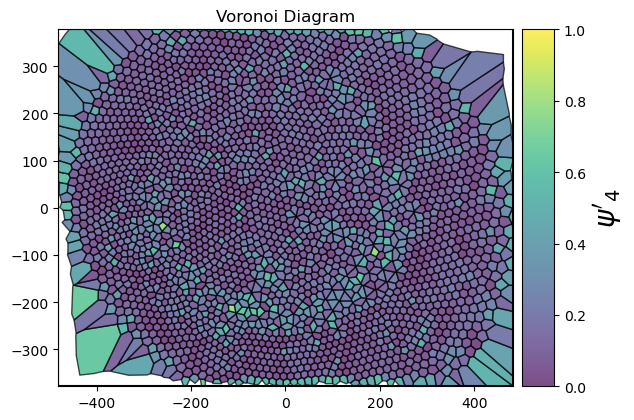

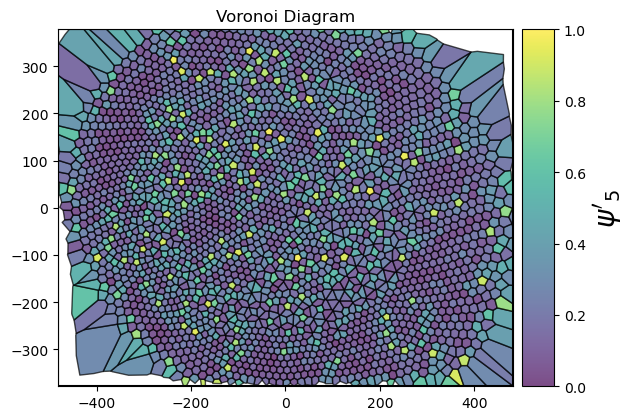

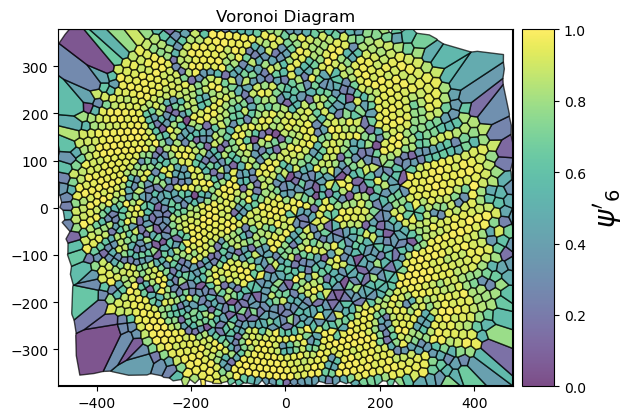

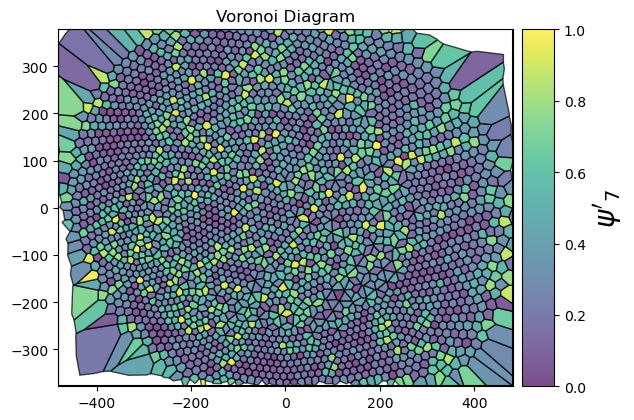

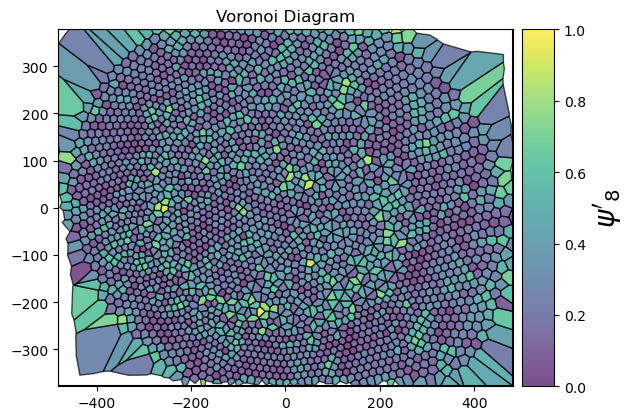

In [ ]:
#going to use a special plot tool
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable 

#we'll set this up as a loop to itterate through multiple order symmetries 
for k in [2, 4, 5, 6, 7, 8]:  #for the different order symmetries ... 
    #find the bond order metric 
    #setting weighted = True calculates the Minkowski order metric otherwise is standard orientation order metric 
    psi = freud.order.Hexatic(k=k, weighted=True) 
    #neighbors and weights are provided from the Voronoi object 
    psi.compute((box,points), neighbors=voro.nlist)
    #Get the magnitude of the order vector (complex vector) to represent order of the cell
    order = np.absolute(psi.particle_order)
    
    #Now Plot each diagram 
    plt.figure()
    ax = plt.gca()
    voro.plot(ax=ax, color_by = 'sides')
    patches = ax.collections[0]
    patches.set_array(order)
    patches.set_cmap("viridis")
    patches.set_clim(0, 1)
    patches.set_alpha(0.7)
    # Remove old colorbar coloring by number of sides
    ax.figure.delaxes(ax.figure.axes[-1])
    ax_divider = make_axes_locatable(ax)
    # Add a new colorbar to the right of the main axes.
    cax = ax_divider.append_axes("right", size="7%", pad="2%")
    cbar = matplotlib.colorbar.Colorbar(cax, patches)
    cbar.set_label(rf"$\psi'_{k}$", size=20)
    ax

#### Comparing Minkowski Order Metrics Heatmap
It can often be useful to compare Minkowski order metrics in a heatmap to try to dicern the type of crystal 

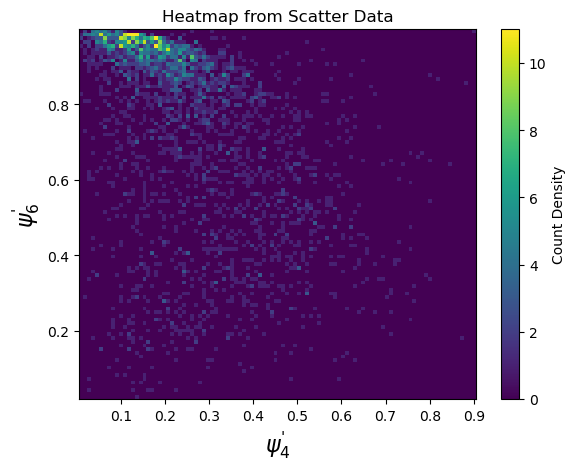

In [24]:
#Start w/ k = 4 vs k = 6 heatmap 

#Find the orders individually like above 
#Find k = 4 order
psi4 = freud.order.Hexatic(k=4, weighted = True)
psi4.compute((box,points), neighbors = voro.nlist) 
order4 = np.absolute(psi4.particle_order) 
#Find k = 6 order 
psi6 = freud.order.Hexatic(k=6, weighted = True) 
psi6.compute((box,points),neighbors = voro.nlist) 
order6 = np.absolute(psi6.particle_order)

#plot q4 vs q6 heatmap 
plt.figure()
heatmap, xedges, yedges = np.histogram2d(order4, order6, bins = 100)
plt.imshow(heatmap.T, origin='lower', extent=[xedges.min(), xedges.max(), yedges.min(), yedges.max()],
           cmap='viridis', aspect='auto')
plt.colorbar(label='Count Density')
plt.title('Heatmap from Scatter Data')
plt.xlabel("$\psi^'_4$",size=16)
plt.ylabel("$\psi^'_6$",size=16)
plt.show()


#### Rotational Variance Maps 
It can also be useful to plot the image in a way to see both the magnitude and angle of the complex vectors for each point. 

* plot over the original image
* plot the magnitude of the vector as the point size (smaller magnitude is smaller points, and vice versa)
* plot the orientation as a colorbar

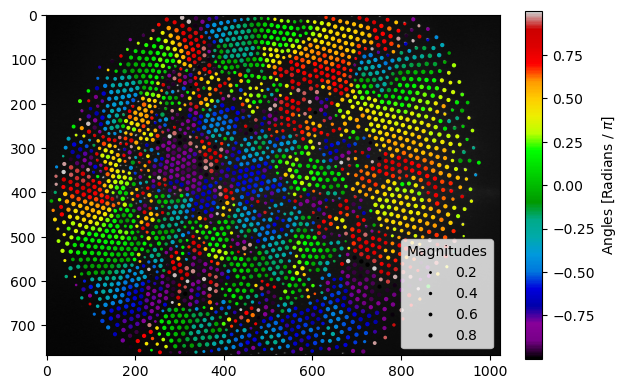

In [81]:
#Find the orders individually like above 
psi = freud.order.Hexatic(k=6, weighted = True)
psi.compute((box,points), neighbors = voro.nlist) 

#pull the magnituedes and orientations from the psi parameter 
magnitudes = np.abs(psi.particle_order)
angles = np.angle(psi.particle_order)

#Plot the figure 
plt.figure()
ax = plt.gca()
plt.imshow(image, cmap = 'Greys_r')
#NB: to plot over the image we need to correct the points from the freud.box 
#NB: magnitueds*5 is for visual scaling
magn_scale = 5
scatter = plt.scatter(points[:,0] + Lx/2, points[:,1] + Ly/2, s = magnitudes*magn_scale, c = angles/np.pi, cmap = 'nipy_spectral')
#NB: colorbar fraction is to scale for visualization, may need to be adjusted for your screen
plt.colorbar(label = "Angles [Radians / $\pi$]", fraction = 0.035) 
#Create the point size legend 
#because we have a magnitude scaler, we need a lambda function to numerically undo the s scaling 
handles, labels = scatter.legend_elements(prop = "sizes", num = 5, alpha = 1, func = lambda s: s/magn_scale) 
legend = ax.legend(handles, labels, loc="lower right", title = "Magnitudes")
plt.show() 